In [ ]:
import sys
import os
sys.path.append('/Users/evatakou/noise_est')

import numpy as np
import matplotlib
from matplotlib import pyplot as plt

from sims.repetition_code_bare_ancilla.repetition_code_bare_ancilla_circuit  import *
from sims.repetition_code_bare_ancilla.construct_dem  import *
from sims.repetition_code_bare_ancilla.estimation_funcs_rep_code  import *
from utilities.utils_for_decoding import decode_both_dems_same_data



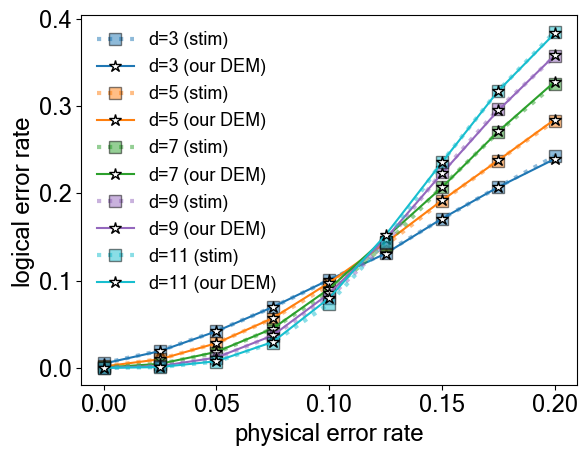

In [ ]:
#W/ PARALLEL PROCESSING
from joblib import Parallel, delayed

matplotlib.rcParams.update({'font.size': 17})
plt.rcParams["font.family"] = "Microsoft Sans Serif" 

fig, ax = plt.subplots()

def process_single_p(p, L, num_shots, Reset, p_depol_after, after_CNOT_depol_type, space_edge_names):
    
    p_data    = p
    p_anc     = p_data
    circuit   = repetition_code_circuit(L, L, p_data, p_anc, Reset, p_depol_after, after_CNOT_depol_type)
    stims_DEM = circuit.detector_error_model()

    defects_matrix             = get_defects(num_shots, circuit, L, L)
    pij_time, pij_bd, pij_bulk = extract_error_probs(defects_matrix)
    my_DEM                     = construct_estimated_DEM(pij_time, pij_bd, pij_bulk, space_edge_names, stims_DEM)
    my_LE, stims_LE            = decode_both_dems_same_data(my_DEM, circuit, num_shots)

    return stims_LE / num_shots, my_LE / num_shots

def plot_threshold(num_shots, p_depol_after, after_CNOT_depol_type, num_vals):
    
    Reset = True
    Ls = [3, 5, 7, 9, 11]
    ps = np.linspace(0, 0.2, num_vals)

    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:purple', 'tab:cyan']

    all_errors_stim = []
    all_errors_my_DEM = []

    for cnt, L in enumerate(Ls):
        num_ancilla = L - 1
        num_rounds = L
        space_edge_names = space_bulk_edge_names(num_rounds, num_ancilla)

        results = Parallel(n_jobs=-1)(
            delayed(process_single_p)(p, L, num_shots, Reset, p_depol_after, after_CNOT_depol_type, space_edge_names)
            for p in ps
        )

        errors_per_p_stim, errors_per_p_my_DEM = zip(*results)

        plt.plot(ps, errors_per_p_stim, marker='s', linestyle=':', color=colors[cnt],
                 linewidth=3, markeredgecolor='black', markersize=9, alpha=0.5)

        plt.plot(ps, errors_per_p_my_DEM, marker='*', color=colors[cnt],
                 markersize=9, markeredgecolor='black', markerfacecolor='white')

        all_errors_stim.append(errors_per_p_stim)
        all_errors_my_DEM.append(errors_per_p_my_DEM)

    plt.legend(['d=3 (stim)', 'd=3 (our DEM)', 
                'd=5 (stim)', 'd=5 (our DEM)', 
                'd=7 (stim)', 'd=7 (our DEM)',
                'd=9 (stim)', 'd=9 (our DEM)', 
                'd=11 (stim)', 'd=11 (our DEM)'],
               frameon=False, shadow=True, fontsize=13)

    plt.xlabel('physical error rate')
    plt.ylabel('logical error rate')
    plt.show()
    
    #Uncomment to save the figure
    # fig.savefig("threshold.pdf",bbox_inches='tight')


    return ps, Ls, all_errors_stim, all_errors_my_DEM


   
num_vals                                = 9             
num_shots                               = 10**6         
p_depol_after                           = 0.025          #Depolarizing strength after CNOT
after_CNOT_depol_type                   = "DEPOLARIZE2"  #Can be DEPOLARIZE1 or DEPOLARIZE2
ps,Ls,all_errors_stim,all_errors_my_DEM = plot_threshold(num_shots,p_depol_after,after_CNOT_depol_type,num_vals)


In [ ]:
#To save the data:

with open("stims_LE_threshold.txt", "w") as file:
    file.write(str(all_errors_stim))
with open("all_errors_my_DEM.txt", "w") as file:
    file.write(str(all_errors_stim))    
with open("ps_threshold.txt", "w") as file:
    file.write(str(ps))   
with open("Ls_threshold.txt", "w") as file:
    file.write(str(Ls))   